In [1]:
import pandas as pd

train_woe = pd.read_csv("../data/processed/train_woe.csv")
test_woe = pd.read_csv("../data/processed/test_woe.csv")

In [2]:
X_train = train_woe.drop(columns=["default"])
y_train = train_woe["default"]

X_test = test_woe.drop(columns=["default"])
y_test = test_woe["default"]


In [3]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver="lbfgs", max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [9]:
# Fill NaNs in test set with 0 (neutral WoE)
X_test = X_test.fillna(0)
X_train = X_train.fillna(0)

train_woe["PD"] = model.predict_proba(X_train)[:,1]
test_woe["PD"] = model.predict_proba(X_test)[:,1]
train_woe.head()

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,...,revol_bal,revol_util,total_acc,grade,sub_grade,home_ownership,verification_status,purpose,default,PD
0,0.168020,0.0,0.006623,0.012905,0.003969,-0.192469,0.209523,0.0,0.062988,0.128323,...,0.008286,-0.035226,-0.008749,-0.943958,-0.905178,-0.037338,0.374922,-0.080097,0,0.324527
1,0.298596,0.0,0.489170,0.321062,0.003969,-0.192469,0.369731,0.0,0.062988,-0.119869,...,0.008286,0.257905,-0.005208,-0.124204,0.101215,-0.155663,0.374922,-0.169724,0,0.171137
2,0.298596,0.0,1.242707,0.321062,0.038717,0.304474,0.369731,0.0,0.062988,-0.015878,...,0.008286,0.257905,-0.005208,1.341565,1.651548,0.148249,0.374922,-0.080097,0,0.019631
3,0.298596,0.0,1.242707,0.321062,-0.092956,-0.192469,0.369731,0.0,-0.278439,0.128323,...,0.008286,0.257905,-0.008749,1.341565,1.651548,-0.155663,0.374922,0.374452,0,0.037602
4,0.298596,0.0,0.489170,0.321062,0.003969,-0.192469,0.369731,0.0,-0.278439,0.128323,...,0.008286,-0.098579,-0.008749,-0.124204,-0.305875,-0.155663,0.374922,0.211112,0,0.201578


In [6]:
from sklearn.metrics import roc_auc_score, confusion_matrix

# AUC
print("Train AUC:", roc_auc_score(y_train, train_woe["PD"]))
print("Test AUC:", roc_auc_score(y_test, test_woe["PD"]))

# Confusion Matrix (optional, using 0.5 cutoff)
print("Train Confusion:\n", confusion_matrix(y_train, train_woe["PD"]>0.5))
print("Test Confusion:\n", confusion_matrix(y_test, test_woe["PD"]>0.5))


Train AUC: 0.7062926080167271
Test AUC: 0.69431846675144
Train Confusion:
 [[670707   3595]
 [148008   4296]]
Test Confusion:
 [[401163   1286]
 [114438   1857]]


In [7]:
import joblib

joblib.dump(model, "../models/logistic_pd_model.pkl")


['../models/logistic_pd_model.pkl']

In [8]:
train_woe.to_csv("../data/processed/train_pd.csv", index=False)
test_woe.to_csv("../data/processed/test_pd.csv", index=False)


In [10]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [12]:

calibrator = CalibratedClassifierCV(estimator=model, method='sigmoid', cv='prefit')
calibrator.fit(X_train, y_train)

c:\Users\VEDANT\anaconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


CalibratedClassifierCV(cv='prefit', estimator=LogisticRegression(max_iter=1000))

In [18]:
# Calibrated PDs for train and test
train_woe["PD_calibrated"] = calibrator.predict_proba(X_train)[:,1]
test_woe["PD_calibrated"] = calibrator.predict_proba(X_test)[:,1]


In [19]:
def plot_calibration(y_true, y_prob, dataset_name):
    # Compute deciles
    df = pd.DataFrame({"y": y_true, "PD": y_prob})
    df["decile"] = pd.qcut(df["PD"], 10, labels=False)
    
    # Actual default rate per decile
    decile_summary = df.groupby("decile").agg(
        avg_predicted=("PD", "mean"),
        actual_default=("y", "mean"),
        count=("y", "count")
    ).reset_index()
    
    # Plot
    plt.figure(figsize=(8,6))
    plt.plot(decile_summary["avg_predicted"], decile_summary["actual_default"], marker='o', label='Observed vs Predicted')
    plt.plot([0,1], [0,1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel("Average Predicted PD")
    plt.ylabel("Observed Default Rate")
    plt.title(f"Calibration / Reliability Chart ({dataset_name})")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"../reports/calibration_{dataset_name.lower()}.png", bbox_inches='tight')
    plt.show()


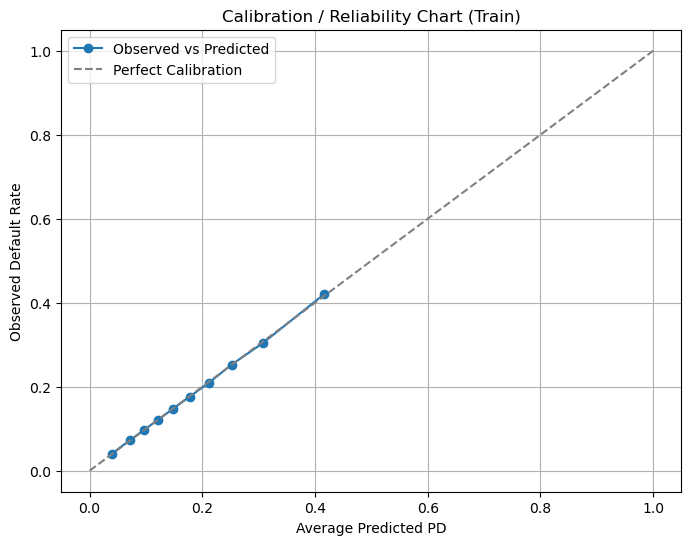

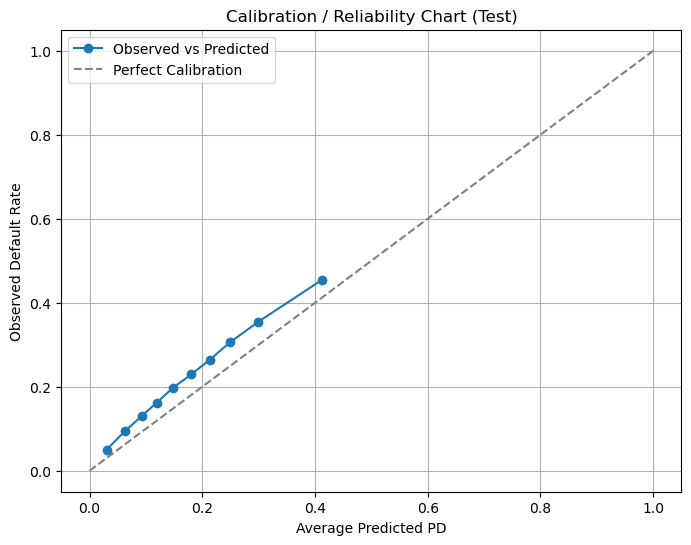

In [20]:
plot_calibration(y_train, train_woe["PD_calibrated"], "Train")
plot_calibration(y_test, test_woe["PD_calibrated"], "Test")
